<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Assignment_2-Feedback/autoencoders-cross-feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, optim

from sklearn.datasets import make_moons
from sklearn.datasets import load_digits

from torch.distributions import Normal

import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

In [ ]:
class Autoencoder(nn.Module):
    ''' Class to model an basic autoencoder with different parameters.
    We reuse this for different tasks.
    '''
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()
        self.encoder = self._build_layers(input_size, bottleneck_size, hidden_size, layers)
        self.decoder = self._build_layers(input_size, bottleneck_size, hidden_size, layers, reverse=True)

    def _build_layers(self, input_size, output_size, hidden_size, layers, reverse=False):
        sizes = [input_size] + [hidden_size] * (layers - 1) + [output_size]
        sizes = [int(size) for size in sizes]  # Ensure all elements are integers
        if reverse:
            sizes.reverse()
        layers = []
        for in_features, out_features in zip(sizes[:-1], sizes[1:]):
            layers.extend([nn.Linear(in_features, out_features), nn.ReLU()])
        layers.pop()  # remove last ReLU
        return nn.Sequential(*layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

<div style="color: green; font-weight:bold">Comment</div>
The class looks good, you fist defined the layers with an own layer builing function and than passed them into a nn.Sequential the sample solution directly works with nn.Sequentials, but the end result is the same. This is even a little more elegant, since it is consice and avoids dublicate code

### Exercise 2.1

In [ ]:
def train_autoencoder(autoencoder, train_data, train_size, epochs, lr):

    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # check if train_size is a tensor
    if torch.is_tensor(train_size):
        train_size = train_size.numel()


    for _ in tqdm(range(int(epochs))):
        optimizer.zero_grad()
        _, outputs = autoencoder(train_data) # + noise
        loss = criterion(outputs, train_data)
        loss.backward()
        optimizer.step()

    return autoencoder

##### Investigating the impact of different hyperparameters

In [ ]:
class AutoencoderExperiments:

    def __init__(self, train_func, hyperparams_dict, data_name) -> None:
        self._train_func = train_func
        self._hyperparams_dict = hyperparams_dict

        self._train_data = AutoencoderExperiments.get_data(data_name, hyperparams_dict["train_size"], hyperparams_dict["initial_noise"])
        self._data_name = data_name
        self._results = None

    @staticmethod
    def get_data(data_name, n_samples, noise):
        temp = None
        if data_name == "moons":
            data, _ = make_moons(n_samples=n_samples, \
                                       noise=noise)
            temp = torch.from_numpy(data).float()

        elif data_name == "digits":
            digits = load_digits()
            data = digits.data / 16.0
            temp = torch.from_numpy(data).float()
        return temp

    def _set_best_hyperparams(self):
        self._best_index = np.argmin(self._results[:, 3])
        self._best_hidden_size, self._best_lr, self._best_epoch, _ = self._results[self._best_index]

    # Exercise 1.1 A
    def optimize_hyperparameters(self):
        # Initialize list to store results
        self._results = []
        self._outputs = {}
        self._inputs = {}


        # Test all combinations of hyperparameters
        for hidden_size in self._hyperparams_dict["hidden_sizes"]:
            for lr in self._hyperparams_dict["learning_rates"]:
                for epoch in self._hyperparams_dict["epochs"]:
                    # Train autoencoder
                    autoencoder = Autoencoder(input_size=2, bottleneck_size=self._hyperparams_dict["bottleneck"], hidden_size=hidden_size, layers=2)
                    trained_autoencoder = self._train_func(autoencoder, self._train_data, train_size=self._hyperparams_dict["train_size"], epochs=epoch, lr=lr)

                    test_data = AutoencoderExperiments.get_data(self._data_name, 1000, 0.1)

                    _,outputs = trained_autoencoder(test_data)
                    self._outputs[str(hidden_size) + str(lr) + str(epoch)] = outputs.detach().numpy()
                    self._inputs[str(hidden_size) + str(lr) + str(epoch)] = test_data.detach().numpy()
                    loss = nn.MSELoss()(outputs, test_data)
                    self._results.append((hidden_size, lr, epoch, loss.item()))

        self._results = np.array(self._results)

    # Convert results to numpy ar


    # Excercise 1.1 A2
    def plot_original_and_reconstructed(self):
        # Select a few hyperparameter settings

        selected_settings = [(hidden_size, lr, epoch) for hidden_size in self._hyperparams_dict["hidden_sizes"][::2]
                            for lr in self._hyperparams_dict["learning_rates"][:3]
                            for epoch in self._hyperparams_dict["epochs"][::2]]

        # take each second value from list using slicing


        #return (selected_settings, self._inputs, self._outputs)

        fig, axes = plt.subplots(nrows=len(selected_settings), ncols=2, figsize=(10, 2*len(selected_settings)))

        for i, (hidden_size, lr, epoch) in enumerate(selected_settings):
            # Get the stored inputs and outputs for these hyperparameters
            inputs = self._inputs[str(hidden_size) + str(lr) + str(epoch)]
            outputs = self._outputs[str(hidden_size) + str(lr) + str(epoch)]

            # Plot original and reconstructed data in separate subplots
            axes[i, 0].scatter(inputs[:, 0], inputs[:, 1], label='Original')
            axes[i, 0].set_title(f'Original: hidden_size={hidden_size}, lr={lr}, epoch={epoch}')
            axes[i, 0].legend()

            axes[i, 1].scatter(outputs[:, 0], outputs[:, 1], label='Reconstructed')
            axes[i, 1].set_title(f'Reconstructed: hidden_size={hidden_size}, lr={lr}, epoch={epoch}')
            axes[i, 1].legend()

        plt.tight_layout()
        plt.show()


    # Exercise 1.1 B
    def investigate_reconstruction(self):
        plt.figure(figsize=(10, 6))
        for hidden_size in self._hyperparams_dict["hidden_sizes"]:
            for lr in self._hyperparams_dict["learning_rates"]:
                mask = (self._results[:, 0] == hidden_size) & (self._results[:, 1] == lr)
                plt.plot(self._results[mask, 2], self._results[mask, 3], label=f'hidden_size={hidden_size}, lr={lr}')
        plt.xlabel('Epochs')
        plt.ylabel('Reconstruction Error')
        plt.legend()
        plt.show()

    # Exercise 1.2
    def reconstruction(self):
        self._set_best_hyperparams()
        reconstruction_errors = []
        for _ in range(10):
            autoencoder = Autoencoder(input_size=2, bottleneck_size=self._hyperparams_dict["bottleneck"], hidden_size=self._best_hidden_size, layers=2)
            #trained_autoencoder = train_autoencoder(autoencoder, train_size=1000, epochs=self._best_epoch, lr=best_lr)
            self._trained_autoencoder = self._train_func(autoencoder, self._train_data, train_size=self._hyperparams_dict["train_size"], epochs=self._best_epoch, lr=self._best_lr)

            # test data
            test_data = AutoencoderExperiments.get_data(self._data_name, 1000, 0.1)

            _, outputs = self._trained_autoencoder(test_data)
            loss = nn.MSELoss()(outputs, test_data)
            reconstruction_errors.append(loss.item())

        # Plot variation in reconstruction error
        plt.figure(figsize=(10, 6))
        plt.plot(reconstruction_errors)
        plt.xlabel('Trial')
        plt.ylabel('Reconstruction Error')
        plt.show()

    # Exercise 1.3 A
    def plot_code_distribution(self):
        test_data = AutoencoderExperiments.get_data(self._data_name, 1000, 0.1)
        self._codes = self._trained_autoencoder.encoder(test_data)
        self._codes = self._codes.detach().numpy()
        plt.hist(self._codes, bins=30, label='Code Distribution')
        plt.title('Code Distribution')
        plt.legend()
        plt.show()

    # Exercise 1.3 B
    def generate_synth_data(self, synth_type="gmm"):
        if synth_type == "gmm":

            # 2. Fit a Gaussian Mixture Model to the code distribution
            scaler = StandardScaler()
            scaled_codes = scaler.fit_transform(self._codes)
            gmm = GaussianMixture(n_components=8)
            gmm.fit(scaled_codes)

            # 3. Sample synthetic data from the GMM and visualize it
            synthetic_codes = gmm.sample(1000)[0]
            synthetic_codes = scaler.inverse_transform(synthetic_codes)
            synthetic_data = self._trained_autoencoder.decoder(torch.from_numpy(synthetic_codes).float()).detach().numpy()
            plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1])
            plt.title('Synthetic Data')
            plt.show()
        elif synth_type == "stdnm":
            # 2. Sample synthetic data from a standard normal distribution and visualize it
            synthetic_codes = Normal(0, 1).sample((1000, self._hyperparams_dict["bottleneck"])).numpy()
            synthetic_data = self._trained_autoencoder.decoder(torch.from_numpy(synthetic_codes).float()).detach().numpy()
            plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1])
            plt.title('Synthetic Data')
            plt.show()

    # Exercise 1.4 check model without retraining with noise (0.2)
    def test_with_noise_without_retraining(self):

        test_data_noisy = AutoencoderExperiments.get_data(self._data_name, 1000, 0.2)

        _, outputs_noisy = self._trained_autoencoder(test_data_noisy)
        loss_noisy = nn.MSELoss()(outputs_noisy, test_data_noisy)
        print(f'Reconstruction error with noise level 0.2: {loss_noisy.item()}')

    # Exercise 1.5 train with noise (0.2)
    def test_with_noise(self):
        # 5. Train a new autoencoder with a training set at noise level 0.2
        train_data_noisy = AutoencoderExperiments.get_data(self._data_name, 1000, 0.2)

        autoencoder_noisy = Autoencoder(input_size=2, bottleneck_size=self._hyperparams_dict["bottleneck"], hidden_size=self._best_hidden_size, layers=2)
        trained_autoencoder_noisy = self._train_func(autoencoder_noisy, self._train_data, train_data_noisy, epochs=self._best_epoch, lr=self._best_lr)

        # Visualize the reconstructed set
        _, outputs_noisy = trained_autoencoder_noisy(train_data_noisy)
        outputs_noisy = outputs_noisy.detach().numpy()
        plt.scatter(outputs_noisy[:, 0], outputs_noisy[:, 1])
        plt.title('Reconstructed Set with Noise Level 0.2')
        plt.show()

In [ ]:
# put hyperparameters in a dictionary
hyperparams_dict = {
    "initial_noise": 0.1,
    "train_size": 1000,
    "bottleneck": 1,
    "hidden_sizes": [10, 20, 30,40, ],       # 50, 100],
    "learning_rates": [0.001, 0.01, 0.1],
    "epochs": [10, 20, 30, 40, ] # 50, 100, 200, 300]
}

experiments1 = AutoencoderExperiments(train_autoencoder, hyperparams_dict=hyperparams_dict, data_name="moons")

In [ ]:
experiments1.optimize_hyperparameters()

100%|██████████| 40/40 [00:00<00:00, 433.96it/s]


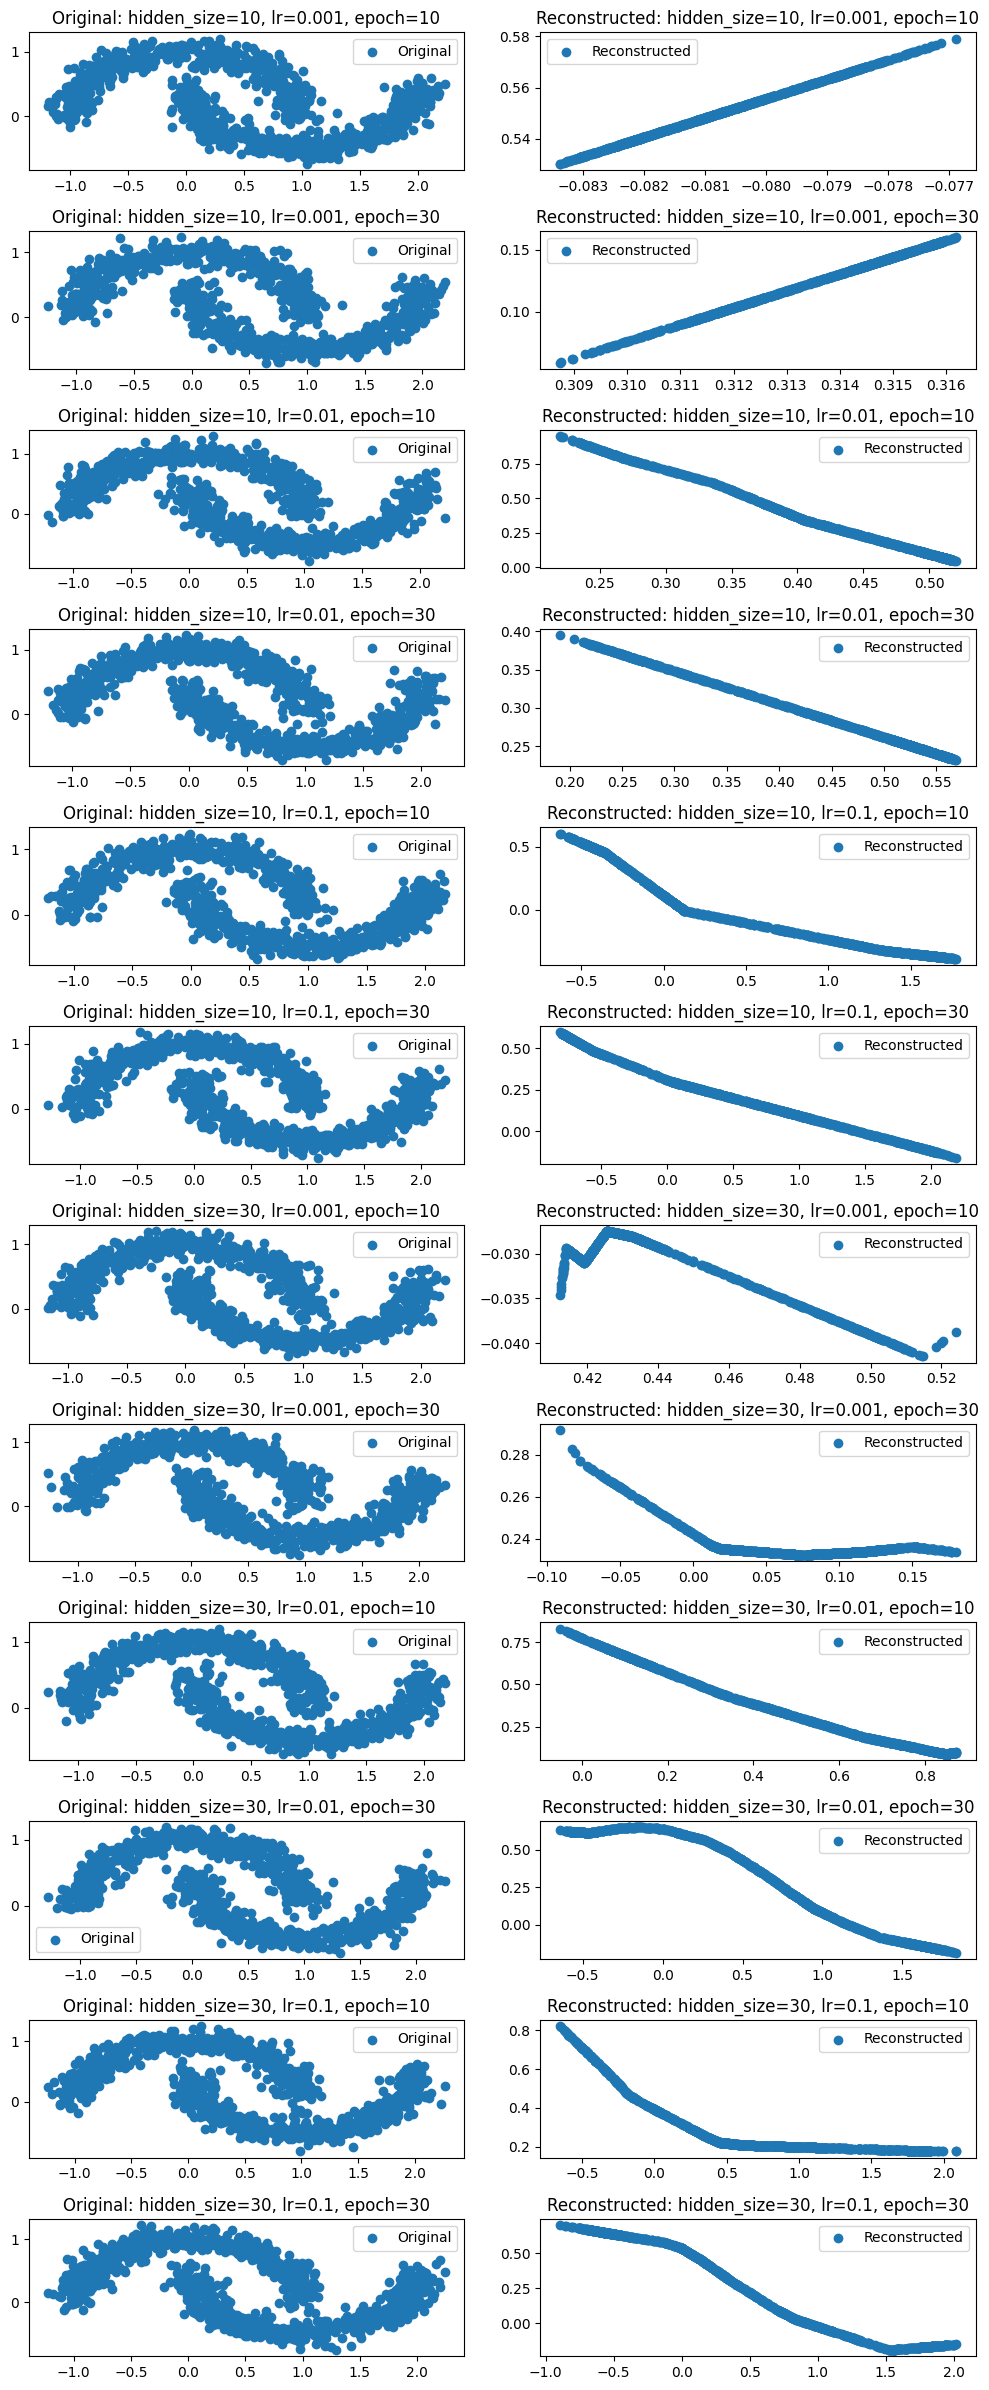

In [ ]:
experiments1.plot_original_and_reconstructed()

### Comments:
These Plots show the original data (left) and the reconstructed data (right) for different hyperparameters (hidden_size, learning rate, and epochs) combinations.

We observe that the reconstruction of the original data is generally inferior in autoencoders that have not undergone sufficient training (due to low epochs or learning rates, or both).
This can be observed by comparing the plots with hidden_size=10, lr=0.1, and epochs 10, 30, 50, and 200.
Or those with hidden_size=30, epoch= 200 and learning rates 0.001, 0.01, 0.1.

We also observe (while not that clearly) that an larger hidden size tends to improve the reconstruction of the original data. The plots show less linear and more curved lines. However, this is not always the case and we are therefore not entirely sure about this observation.

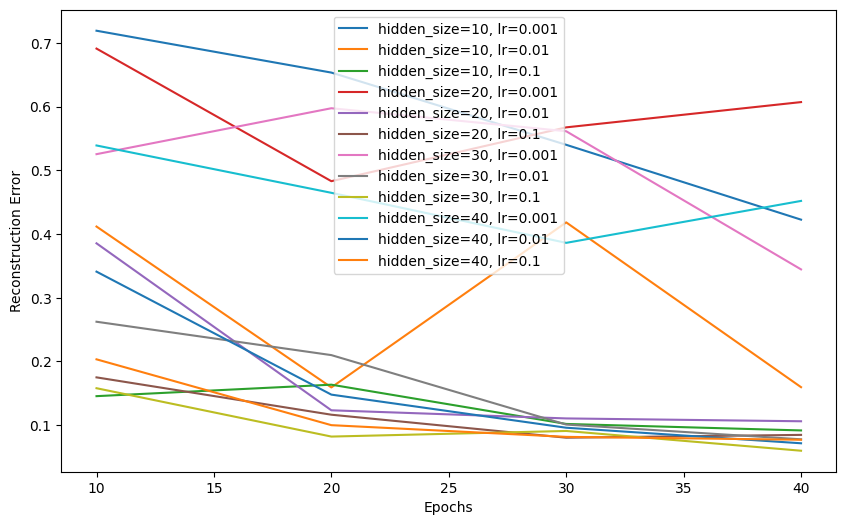

In [ ]:
experiments1.investigate_reconstruction()

### Comments:
This plot shows the reconstruction error (y-axis) for different hyperparameters (hidden_size, learning rate, and epochs) combinations with an increasing number of epochs (x-axis).
We observe that while there is a higher fluctuarion in the reconstruction error for less epochs among most combinations, the general trend is that the reconstruction error decreases with an increasing number of epochs. This is expected as the autoencoder is trained more and more. We again observe that the reconstruction error is generally higher for autoencoders that have not undergone sufficient training (due to low epochs or learning rates), with the hidden_sizes again not showing a clear trend (although the error seems to be lower for larger hidden sizes, especially >20).

100%|██████████| 40/40 [00:00<00:00, 458.26it/s]


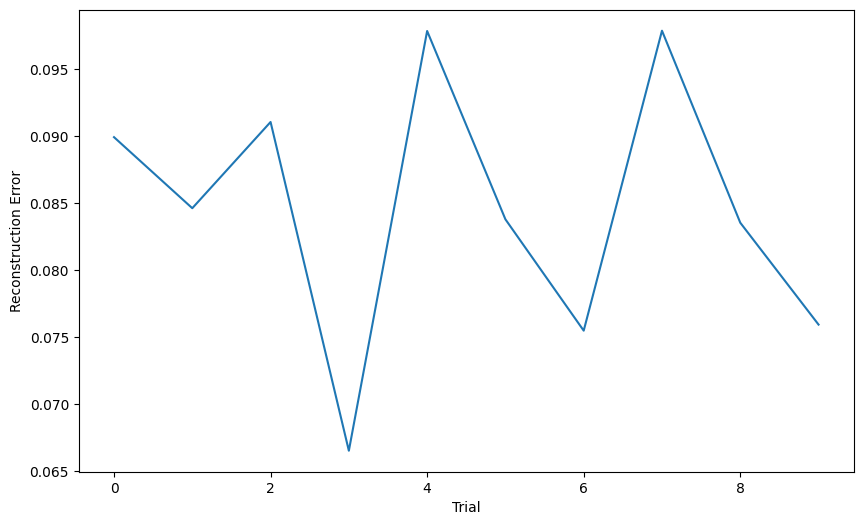

In [ ]:
experiments1.reconstruction()

### Comments:
This plot shows the reconstruction error (y-axis) for the in the previous plot best performing hyperparameter combination, throughout 10 different runs (x-axis) on independent data sets.

We observe that the change in the measured reconstruction error is not that large between the different runs, indicating that we did not just pick a good hyperparameter combination by chance.

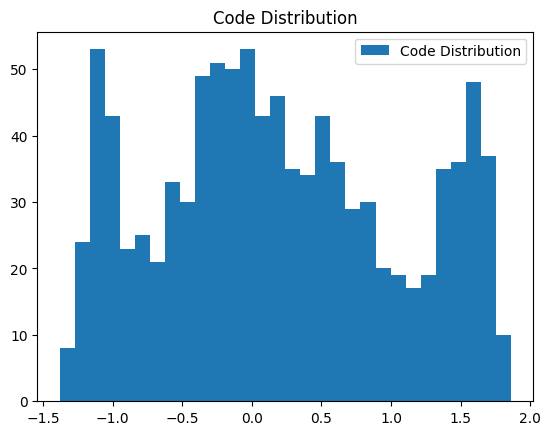

In [ ]:
experiments1.plot_code_distribution()

### Comments:
This plot shows the encoded distribuiton of the encoder in a subdimensional space (bottleneck size = 1). While the center of the distribution at around 0 is expected because this is also the center of the original moons data, we observe that the distribution is not symmetric around this center but rather extends further skewed to the right. We are not sure why this is the case however, one idea is that because the autoencoder is not able represent the data in the same way in a 1-dimensional space, it has to use different parts of the space (i.e. the right side) to represent additional information.

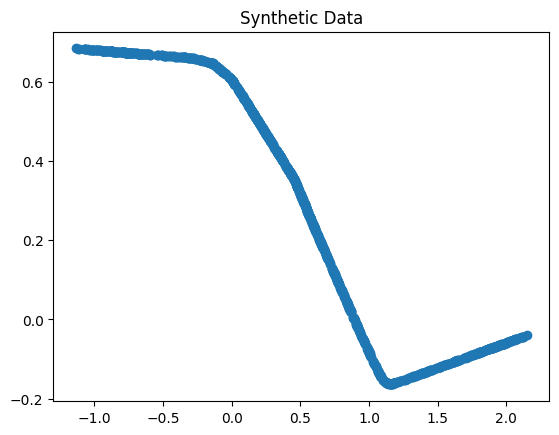

In [ ]:
experiments1.generate_synth_data()

### Comments:
The "Synthetic Data" plot visualizes the two dimensional synthetic data that was generated by an Gaussian Mixture Model on top of the trained autoencoder. We observe that the data is distributed similarly to the original moons data, however the two moon clusters are not clearly seperated which is expected as the autoencoder is not able to represent the data in the same way in a 1-dimensional space. Overall it seems to be a pretty good representation of the original distribution.

In [ ]:
experiments1.test_with_noise_without_retraining()

Reconstruction error with noise level 0.2: 0.09623906016349792


100%|██████████| 40/40 [00:00<00:00, 371.95it/s]


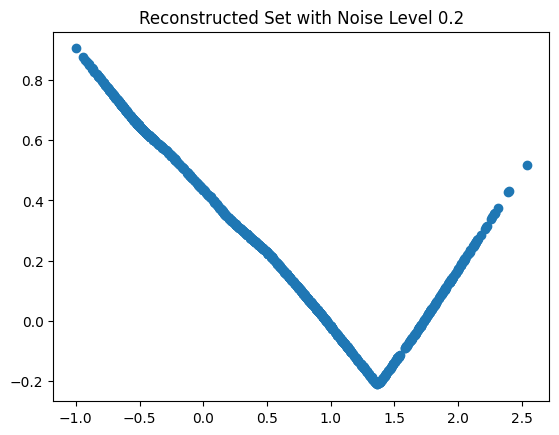

In [ ]:
experiments1.test_with_noise()

### Comments:
When comparing this plot, with the Synthetic Data plot, we don't see too much of a difference that additional noise would bring us. One marginal thing that it seems to do is to spread out the distribution a bit more and smooth it out.

! The Assignment didn't specify if we should actually use a GMM to sample. This is why we just transformed the original noisy data with the autoencoder trained on noisy data. We are not sure if this is what was intended.
Additionally we were suprised that this is then so similar to the Synthetic Data plot which uses the GMM to sample.

### Exercise 2.2

In [ ]:
def compute_kernel(x, y, bandwidths):
    if len(x.shape) == 1:
        x = x.unsqueeze(0)
    if len(y.shape) == 1:
        y = y.unsqueeze(0)
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx
    dyy = ry.t() + ry - 2. * yy
    dxy = rx.t() + ry - 2. * zz

    XX, YY, XY = (torch.zeros(xx.shape).to(x.device) for _ in range(3))

    for bandwidth in bandwidths:
        XX += torch.exp(-0.5 * dxx / bandwidth)
        YY += torch.exp(-0.5 * dyy / bandwidth)
        XY += torch.exp(-0.5 * dxy / bandwidth)

    return XX, YY, XY

def compute_mmd(x, y, bandwidths=[1, 2, 4]):
    XX, YY, XY = compute_kernel(x, y, bandwidths)
    return torch.mean(XX) + torch.mean(YY) - 2. * torch.mean(XY)

#train_autoencoder(autoencoder, train_data, train_size, epochs, lr)
def train_mmd_autoencoder(autoencoder, train_data, train_size, epochs, lr, mmd_weight=1, include_mse=True, bottleneck_size=2):
    criterion = nn.MSELoss()
    # check if train_size is a tensor
    if torch.is_tensor(train_size):
        train_size = train_size.numel()

    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    normal_dist = Normal(torch.zeros(bottleneck_size), torch.ones(bottleneck_size))

    for epoch in range(int(epochs)):
        optimizer.zero_grad()
        encoded, decoded = autoencoder(train_data)
        mse_loss = criterion(decoded, train_data)
        mmd = compute_mmd(encoded, normal_dist.sample((train_data.size(0),)))
        loss = mse_loss + mmd_weight * mmd
        loss.backward()
        optimizer.step()

    return autoencoder

<div style="color: green; font-weight:
bold">Comment:</div>

* The `train_mmd_encoder` function is similar to the one in the sample solution!

In [ ]:
# put hyperparameters in a dictionary
hyperparams_dict = {
    "initial_noise": 0.1,
    "train_size": 1000,
    "bottleneck": 2,
    "hidden_sizes": [10, 20, 30,40, 50, 100],
    "learning_rates": [0.001, 0.01, 0.1],
    "epochs": [10, 20, 30, 40, 50, 100, 200, 300]
}

experiments2 = AutoencoderExperiments(train_mmd_autoencoder, hyperparams_dict=hyperparams_dict, data_name="moons")

In [ ]:
experiments2.optimize_hyperparameters()

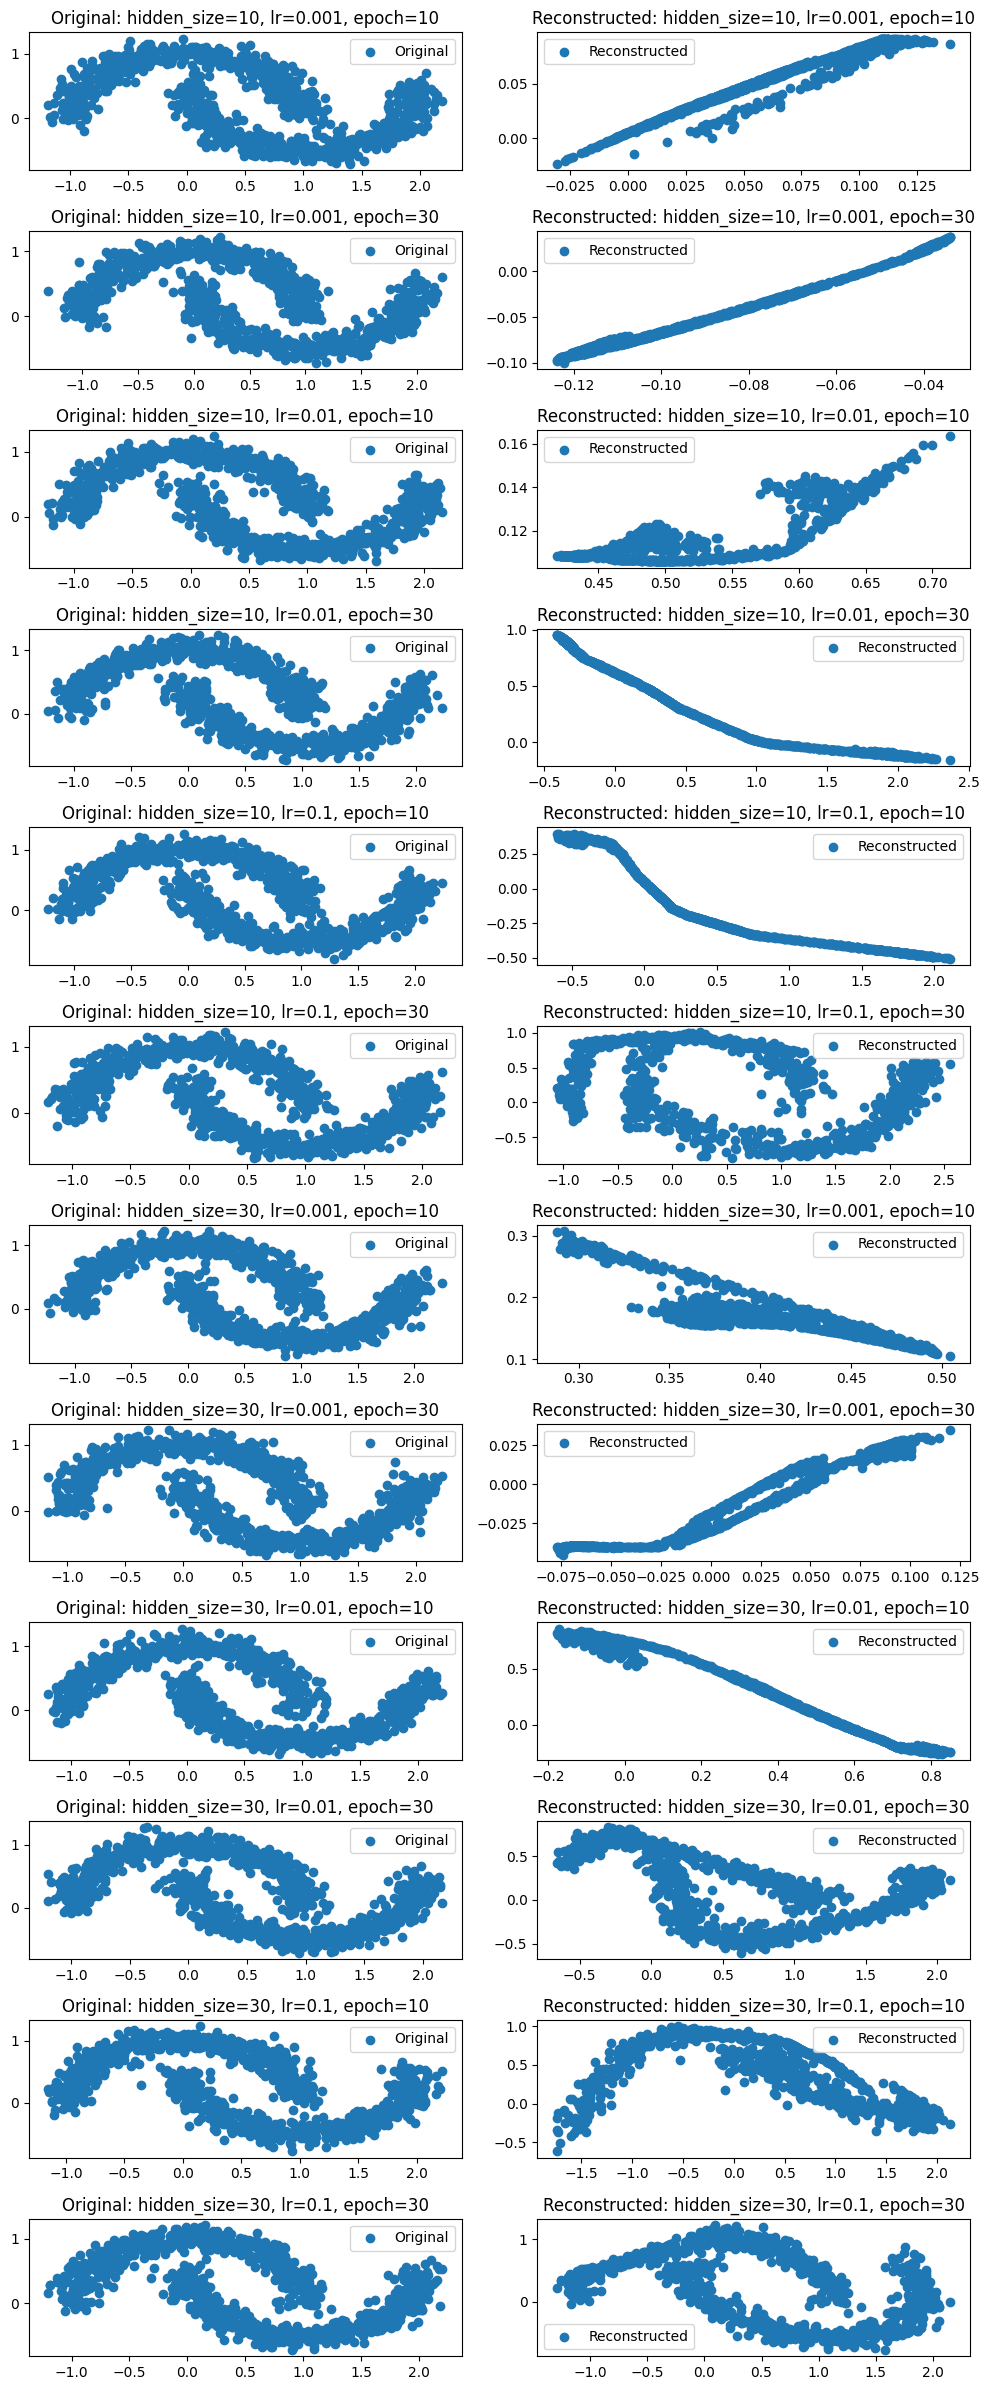

In [ ]:
experiments2.plot_original_and_reconstructed()

### Comments:
When looking at these plots again, but now in the context of an autoencoder without bottleneck (bottleneck=2), we observe that the reconstruction varies a lot when choosing different hyperparameter-combinations. However, in principle when the right parameters are chosen, the recostruction is very close to the original data and even matches similar patterns in variations (more complex than just lines as in the previous plots). This is expected as the autoencoder has more space to represent the data in a 2-dimensional space.
We think that the reason to why the reconstruction is not always good is lack of training.

<div style="color: green; font-weight:
bold">Comment:</div>

Suggestion: Always plot the the original dataset and the generated/reconstructed dataset in the same plot!

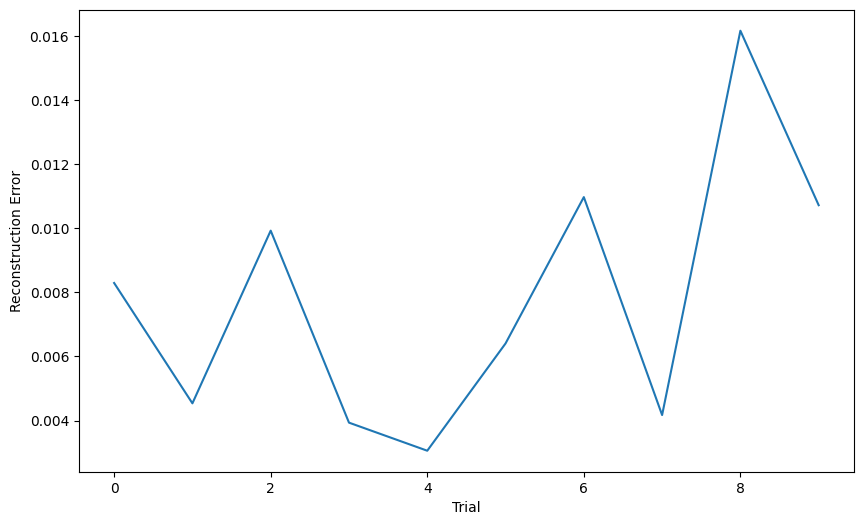

In [ ]:
experiments2.reconstruction()

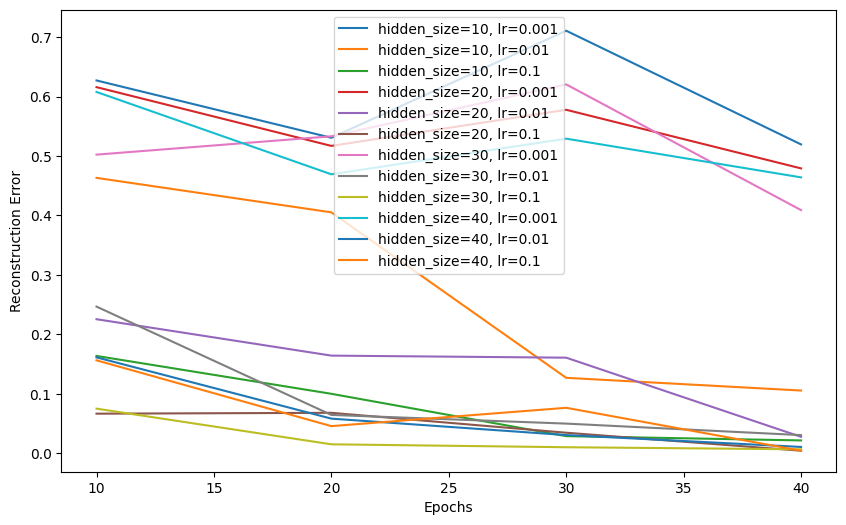

In [ ]:
experiments2.investigate_reconstruction()

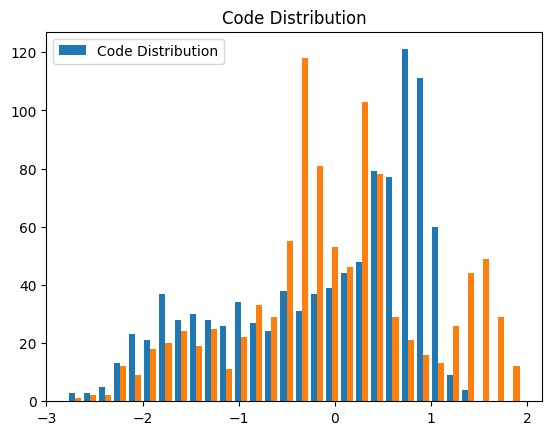

In [ ]:
experiments2.plot_code_distribution()

<div style="color: green; font-weight:
bold">Comment:</div>

* Please be explicit about what you are plotting. From what we understand, this is a histogram plot for both the components of the code dataset. Legend is incorrect and there is no mention of the choice of parameters and hyperparameters of the model for which you have plotted this histogram!

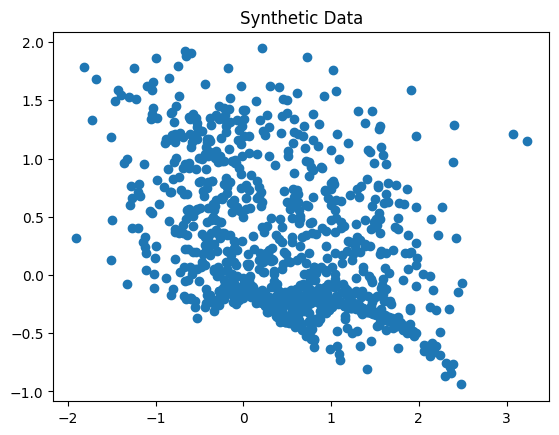

In [ ]:
experiments2.generate_synth_data(synth_type="stdnm")

<div style="color: green; font-weight:
bold">Comment:</div>

* Overall the solution presented for the task 2 is MISSES the MOST IMPORTANT THING that was asked to explore in the **assignment**:
  * Effect of the different sizes of the bandwidths,
  * Effect of different values of the MMD values.

* The sample solution is clearly way more elegant than your solution!

* Proceed in the manner of the sample solution. Note that in the sample solution, they have considered the resnet model. You can continue with your autoencoder model and try to explore the effect of different hypermeteres on the quality of the reconstructed data set as well as the quality of the synthetically geenrated dataset for all differernt cases!



### Exercise 2.3

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

class RFClassifier:

    def __init__(self):
        self._clf = RandomForestClassifier(n_estimators=100, random_state=42)

    def train(self, x_train, y_train):
        self._clf.fit(x_train, y_train)

    def predict(self, x_test):
        return self._clf.predict(x_test)

    def calc_accuracy(self, y_test, y_pred):
        return accuracy_score(y_test, y_pred)

In [ ]:
def separate_data(digits):
    data = digits.data / 16.0
    data = torch.from_numpy(data).float()
    X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, data

Accuracy on original test set: 0.9722222222222222


100%|██████████| 1000/1000 [00:04<00:00, 200.56it/s]


Accuracy on reconstructed test set: 0.8222222222222222


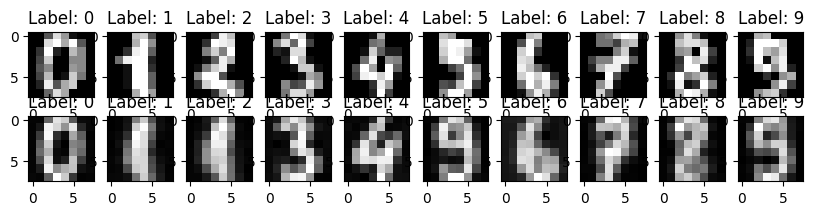

100%|██████████| 1000/1000 [00:04<00:00, 209.20it/s]


Accuracy on reconstructed test set: 0.9027777777777778


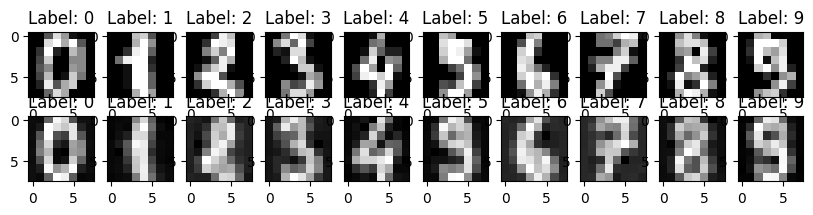

100%|██████████| 1000/1000 [00:04<00:00, 200.03it/s]


Accuracy on reconstructed test set: 0.9638888888888889


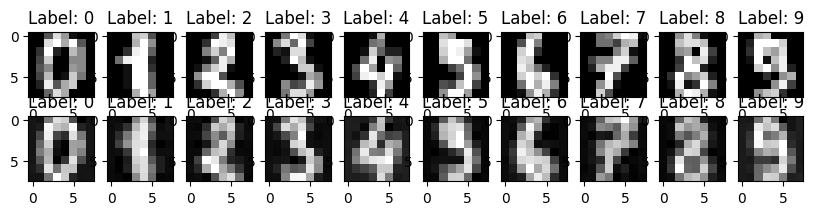

In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
digits = load_digits()
X_train, X_test, y_train, y_test, data = separate_data(digits)

# train random forest classifier
clf = RFClassifier()
clf.train(X_train, y_train)
y_pred_original = clf.predict(X_test)
#print("Predictions on original test set:", y_pred_original)
print("Accuracy on original test set:", clf.calc_accuracy(y_test, y_pred_original))

for bottleneck_size in [2, 4, 8]:
    autoencoder = Autoencoder(input_size=64, bottleneck_size=bottleneck_size, hidden_size=128, layers=2)
    trained_autoencoder = train_autoencoder(autoencoder, data, train_size=1797, epochs=1000, lr=0.001)

    # entire dataset
    _, reconstructions = trained_autoencoder(data)
    reconstructions = reconstructions.detach().numpy()

    # test dataset
    _, X_recon_test = trained_autoencoder(X_test)
    X_recon_test = X_recon_test.detach().numpy()

    y_pred_recon = clf.predict(X_recon_test)
    #print("Predictions on reconstructed test set:", y_pred_recon)
    print("Accuracy on reconstructed test set:", clf.calc_accuracy(y_test, y_pred_recon))

    # Visualize the reconstructions
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 2))
    #fig.subplots_adjust(hspace=0.5)  # adjust this value to your needs
    # Add captions
    #axes[0, 0].set_title("Original images")
    #axes[1, 0].set_title("Reconstructions")
    for i in range(10):
        axes[0, i].imshow(digits.data[i].reshape(8, 8), cmap='gray')
        axes[0, i].set_title(f'Label: {digits.target[i]}')  # add caption to original image
        axes[1, i].imshow(reconstructions[i].reshape(8, 8), cmap='gray')
        axes[1, i].set_title(f'Label: {digits.target[i]}')  # add caption to reconstruction

    plt.show()

Even though the generated images look slightly worse than the original ones, the classification accuracy is still pretty high. This could be due to the network learning the most important features to distinguish digits. Clearly, increasing bottleneck size improves the performance.